In [1]:
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping



2024-11-12 17:12:23.608577: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-12 17:12:23.611583: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-12 17:12:23.620173: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-12 17:12:23.633912: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-12 17:12:23.638003: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-12 17:12:23.649374: I tensorflow/core/platform/cpu_feature_gu

### Import Data

In [2]:
import pandas as pd

lupa_df = pd.read_csv('/workspaces/time-series-project-tutorial/acea-water-prediction/Water_Spring_Lupa.csv')
lupa_df.head()

,Date,Rainfall_Terni,Flow_Rate_Lupa
0,01/01/2009,2.797,NaN
1,02/01/2009,2.797,NaN
2,03/01/2009,2.797,NaN
3,04/01/2009,2.797,NaN
4,05/01/2009,2.797,NaN


In [3]:
lupa_df.isnull().sum()
lupa_df = lupa_df.dropna()
print(lupa_df)

            Date  Rainfall_Terni  Flow_Rate_Lupa
49    19/02/2009           2.763         -166.02
50    20/02/2009           2.763         -166.97
51    21/02/2009           2.763         -167.72
52    22/02/2009           2.763         -168.65
53    23/02/2009           2.763         -169.42
...          ...             ...             ...
4194  26/06/2020           0.000          -73.93
4195  27/06/2020           0.000          -73.60
4196  28/06/2020           0.000          -73.14
4197  29/06/2020           0.000          -72.88
4198  30/06/2020           0.000          -72.55

[3817 rows x 3 columns]


### Format Time Series Date Field

In [4]:
from datetime import datetime

original_date = lupa_df['Date']
parsed_date = original_date.apply(lambda x: datetime.strptime(x, "%d/%m/%Y"))

# Format to mm/dd/yyyy
lupa_df['formatted_date'] = pd.to_datetime(lupa_df['Date'], format="%d/%m/%Y").dt.strftime("%m/%d/%Y")

print(lupa_df['formatted_date'])


49      02/19/2009
50      02/20/2009
51      02/21/2009
52      02/22/2009
53      02/23/2009
           ...    
4194    06/26/2020
4195    06/27/2020
4196    06/28/2020
4197    06/29/2020
4198    06/30/2020
Name: formatted_date, Length: 3817, dtype: object


In [5]:
lupa_df = lupa_df.set_index('formatted_date')
lupa_df = lupa_df.drop(columns=['Date'])
lupa_df.head()

,Rainfall_Terni,Flow_Rate_Lupa
formatted_date,,
02/19/2009,2.763,-166.02
02/20/2009,2.763,-166.97
02/21/2009,2.763,-167.72
02/22/2009,2.763,-168.65
02/23/2009,2.763,-169.42


In [6]:
lupa_df.columns

Index(['Rainfall_Terni', 'Flow_Rate_Lupa'], dtype='object')

## Multivariate Analysis - LSTM 

### Min Max Scaling

#### Function to Min Max scale multiple features

In [9]:
target_columns = ['Flow_Rate_Lupa']
feature_columns = lupa_df.drop(columns=target_columns).columns.tolist()

#target_columns.dtypes

In [10]:
# Ensure X is defined

def prepare_feature_data(df, feature_columns, target_columns, lookback=30):
    """
    Prepare multi-feature sequences for LSTM model
    """
    
    X, y = [], []
    # Scale the features
    scaler_features = MinMaxScaler()
    scaled_features = scaler_features.fit_transform(df[feature_columns])
    
    # Scale the target separately
    scaler_target = MinMaxScaler()
    scaled_target = scaler_target.fit_transform(df[target_columns])
    
    for i in range(len(df) - lookback):
        # Features: take all feature columns for the lookback period
        X.append(scaled_features[i:(i + lookback)])
        # Targets: take all target columns for the prediction point
        y.append(scaled_target[(i + lookback)])
    
    return X, y, scaler_features, scaler_target

# Call the function with debugging
try:
    X, y, scaler_features, scaler_target = prepare_feature_data(lupa_df, feature_columns, target_columns, lookback=30)
    print(scaler_target)
except ValueError as e:
    print("ValueError encountered:", e)
    # print("lupa_df shape:", lupa_df.shape)
    # print("feature_columns:", feature_columns)
    # print("target_columns:", target_columns)
    # print("lookback:", 7)





MinMaxScaler()


#### Define Test Train Split Myself <br>

In [11]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
test_size = len(X) - train_size
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
#print(y_train)


Train size: 3029, Test size: 758


### LSTM Model Multi-Target

In [12]:
from tensorflow.keras.layers import Bidirectional

n_features = len(feature_columns)

model = Sequential([
    # Increase capacity for better pattern recognition
    Bidirectional(LSTM(128, return_sequences=True, input_shape=(30, n_features))),
    Dropout(0.3),
    
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    
    Bidirectional(LSTM(32)),
    Dropout(0.3),
    
    Dense(32, activation='relu'),
    Dense(1)
])

# Use Huber loss to handle outliers better
model.compile(optimizer=Adam(learning_rate=0.001), loss='huber')

/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### Define Early Stopping to precvent Overfitting 

In [13]:
# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=5,          # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)



In [14]:
import numpy as np

# Convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)

# Ensure the shapes are compatible
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    validation_split=0.2,  # Use 20% of the training data for validation
    epochs=100,            # Set a high number of epochs; early stopping will stop it earlier if needed
    batch_size=32,         # Adjust batch size based on your dataset size
    callbacks=[early_stopping],
    verbose=1              # Print training progress
)

X_train shape: (3029, 30, 1)
y_train shape: (3029, 1)
Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 16s 121ms/step - loss: 0.0272 - val_loss: 0.0012
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - loss: 0.0037 - val_loss: 2.5769e-04
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - loss: 0.0040 - val_loss: 4.7493e-04
Epoch 4/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.0038 - val_loss: 5.5271e-04
Epoch 5/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - loss: 0.0030 - val_loss: 9.1679e-04
Epoch 6/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 0.0030 - val_loss: 0.0016
Epoch 7/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - loss: 0.0029 - val_loss: 0.0017


### Model Predictions
We train the model on the train data and the test data to see how well <br>
we are predicting the training and testing data

In [15]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

print(test_pred)

95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
[[0.44718638]
 [0.4476368 ]
 [0.44807863]
 [0.44851342]
 [0.44894367]
 [0.44937205]
 [0.44980156]
 [0.4502352 ]
 [0.4506756 ]
 [0.45112535]
 [0.45158592]
 [0.45205852]
 [0.4525431 ]
 [0.45303866]
 [0.45354253]
 [0.45405057]
 [0.45455673]
 [0.45505255]
 [0.45552692]
 [0.45596552]
 [0.45634878]
 [0.4562778 ]
 [0.45579475]
 [0.45523956]
 [0.4546411 ]
 [0.4540199 ]
 [0.45339093]
 [0.45276397]
 [0.45214522]
 [0.4515376 ]
 [0.4509421 ]
 [0.45035765]
 [0.44978195]
 [0.44921193]
 [0.4486438 ]
 [0.44807363]
 [0.4474974 ]
 [0.44691145]
 [0.44631264]
 [0.44569835]
 [0.4450673 ]
 [0.44441923]
 [0.44375566]
 [0.4430799 ]
 [0.44239762]
 [0.44171706]
 [0.44104952]
 [0.44041005]
 [0.43981847]
 [0.43920466]
 [0.43867302]
 [0.4385294 ]
 [0.43837455]
 [0.43821374]
 [0.43805084]
 [0.43788838]
 [0.437728  ]
 [0.43757036]
 [0.43741578]
 [0.43726397]
 [0.43711442]
 [0.43696618]
 [0.4368185 ]
 [0.43667024]
 [0.43652046]
 [0.436368

### Convert back to normal scale

In [16]:
# Inverse transform predictions
train_pred = scaler_target.inverse_transform(train_pred)
test_pred = scaler_target.inverse_transform(test_pred)
y_train_orig = scaler_target.inverse_transform(y_train)
y_test_orig = scaler_target.inverse_transform(y_test)



### Evaluate Loss

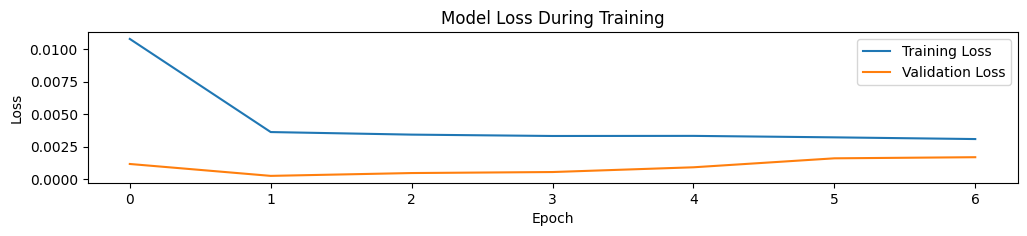

In [17]:
import matplotlib.pyplot as plt


# Create visualizations
plt.figure(figsize=(12, 9))

# Plot 1: Training Loss
plt.subplot(4, 1, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

## Evaluate Progress

In [18]:
def evaluate_regression_lstm(y_true, y_pred):
    # R² score (1.0 is perfect prediction)
    r2 = r2_score(y_true, y_pred)
    
    # Mean Absolute Error
    mae = mean_absolute_error(y_true, y_pred)
    
    # Root Mean Squared Error
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # Custom accuracy metric for regression (as percentage)
    # Using 1 - normalized MAE as a proxy for accuracy
    #accuracy = (1 - mae / (y_true.max() - y_true.min())) * 100
    
    print("\nRegression Metrics:")
    print(f"R² Score: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    #print(f"Accuracy (based on normalized MAE): {accuracy:.2f}%")
    
    return r2, mae, rmse

### Evaluate 3 Targets

In [19]:
evaluate_regression_lstm(y_test_orig, test_pred)


Regression Metrics:
R² Score: -0.7434
MAE: 10.1838
RMSE: 10.9864


(-0.7433800161369479, 10.183776517681837, 10.9863701333509)

## Plot Residuals - Actual vs Predicted

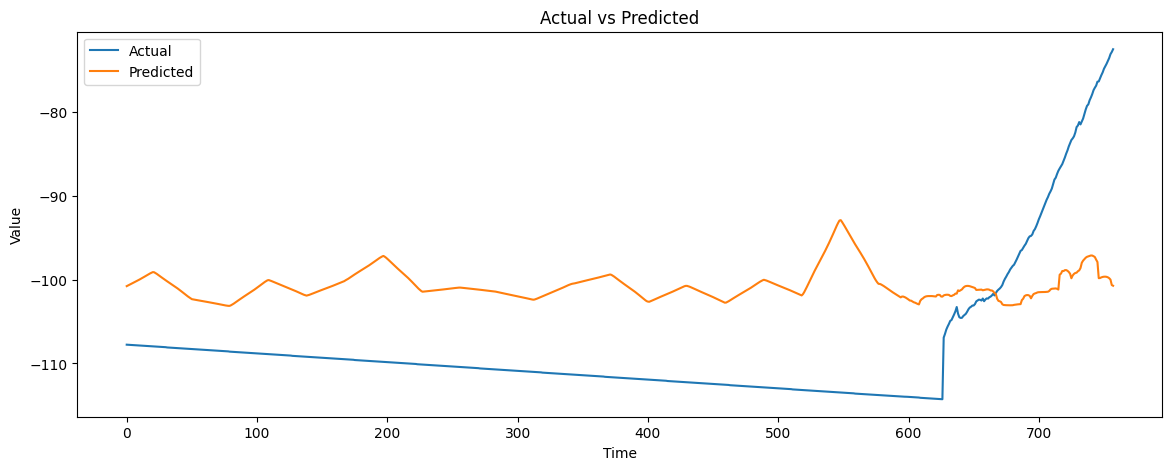

In [20]:
import matplotlib.pyplot as plt

def plot_actual_vs_predicted(y_true, y_pred, title='Actual vs Predicted'):
    plt.figure(figsize=(14, 5))
    plt.plot(y_true, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Assuming y_test and test_pred are defined
plot_actual_vs_predicted(y_test_orig, test_pred)


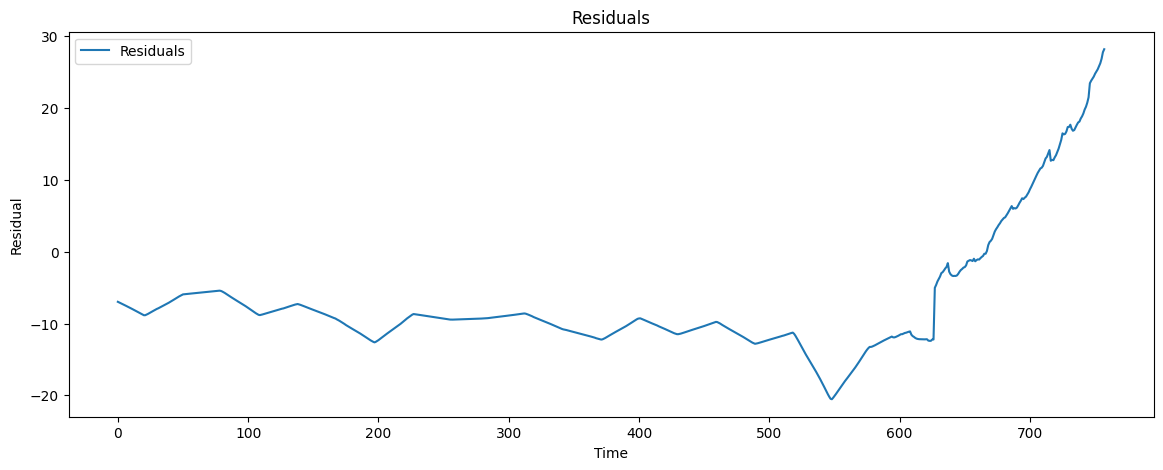

: 

In [21]:
def plot_residuals(y_true, y_pred, title='Residuals'):
    residuals = y_true - y_pred
    plt.figure(figsize=(14, 5))
    plt.plot(residuals, label='Residuals')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Residual')
    plt.legend()
    plt.show()
    
    
plot_residuals(y_test_orig, test_pred, title='Residuals')

## Find Optimal Learning Rate 

### Find Optimal Learning Rate 

In [ ]:
def find_optimal_lr(model, X_train, y_train):
    lr_schedule = np.logspace(-4, -2, 100)  # Test from 0.0001 to 0.01
    losses = []
    
    for lr in lr_schedule:
        model.optimizer.learning_rate.assign(lr)
        loss = model.train_on_batch(X_train[:32], y_train[:32])
        losses.append(loss)
        
    best_lr = lr_schedule[np.argmin(losses)]
    return best_lr

find_optimal_lr(model, X_train, y_train)